# Large, all encompassing societal events influence the Billboard Hot 100

This can be seen in the music we listened to during the Great Recession and the increase in explicit content when we feel low life satisfaction.

## High-energy, danceable music increases during slow economic times.

Give people the escape they need by producing high-tempo, danceable music. Just don't pander to them with out of touch, overly happy sounds.

## Popularity in explicit content rises with anger.

Music might be used as a release.

## Smaller events do not seem to have an effect.

Trying to cater to the public by responding to smaller events that may not affect the majority of the general population to the same degree may not be worth pursuing.

# Exploration

#### I will be conducting analysis on the Billboard Hot 100 and Spotify audio features datasets to determine if specific **societal events** influence music listener preferences, and, if so, which ones and to what extent, for **my stakeholders, the record label executives.**

## My Libraries

- **Google:** to load the data
- **Pandas:** my Swiss Army Knife
- **Numpy:** to work with arrays
- **Matplotlib.pyplot:** visualations such as graphs
- **Fred:** to access Federal Reserve Economic Data
- **Statistics:** to calculate variance
- **YFinance:** to access stock market data
- **MusicBrainzngs:** to add a gender column to artist data
- **Time:** to limit requests to one per second
- **Warnings:** to make the notebook cleaner by removing warnings

In [725]:
!pip install musicbrainzngs

python(90020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
!pip install yfinance

In [727]:
from google.auth import load_credentials_from_file
from google.cloud.bigquery import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from statistics import variance
import yfinance
import musicbrainzngs as mb
import time # time enables the delay 
import warnings

warnings.filterwarnings('ignore')

### Fred Key Information:

If you want to run the cells for the GPD and Unemployment charts from the FRED, you'll need to request an API Key. Apologies if this is not the best way to do this, I wasn't able to find a way to hide my key so you could run it.

[FRED site:] (https://fred.stlouisfed.org/docs/api/api_key.html)

In [1107]:
fred_key='your-key-here'

In [510]:
fred = Fred(api_key=fred_key)

## Data Loading and Cleaning

In [133]:
credentials, project_id = load_credentials_from_file('service_account.json')

client = Client(
    project=project_id,
    credentials=credentials
)

In [135]:
def load_data(table):
    query = f"SELECT * FROM `da26-python.music_data.{table}`"
    load_job = client.query(query)
    data = load_job.to_dataframe()
    return data

In [137]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str)
    except:
        try:
            if len(str(date_str)) >= 4:
                year = int(str(date_str)[:4])
                return pd.to_datetime(f"{year}-01-01")
        except:
            return pd.NaT

In [139]:
audio_features = load_data("audio_features")
chart_positions = load_data("chart_positions")
artists = load_data("artists")
tracks = load_data("tracks")
tracks_artists = load_data("tracks_artists_mapping")

In [381]:
chart_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129305 entries, 0 to 129304
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   chart_week     129305 non-null  dbdate
 1   list_position  129305 non-null  Int64 
 2   track_id       129305 non-null  object
dtypes: Int64(1), dbdate(1), object(1)
memory usage: 3.1+ MB


In [140]:
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          10776 non-null  object 
 1   danceability      10776 non-null  float64
 2   energy            10776 non-null  float64
 3   key               10776 non-null  float64
 4   loudness          10776 non-null  float64
 5   mode              10776 non-null  float64
 6   speechiness       10776 non-null  float64
 7   acousticness      10776 non-null  float64
 8   instrumentalness  10776 non-null  float64
 9   liveness          10776 non-null  float64
 10  valence           10776 non-null  float64
 11  tempo             10776 non-null  float64
 12  time_signature    10776 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [474]:
tracks.rename(columns={'name': 'track_name'}, inplace=True)

In [464]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11070 entries, 0 to 11069
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   track_id      11070 non-null  object 
 1   track_name    11070 non-null  object 
 2   duration_ms   11070 non-null  Int64  
 3   release_date  11070 non-null  object 
 4   album_type    11070 non-null  object 
 5   explicit      11070 non-null  boolean
dtypes: Int64(1), boolean(1), object(4)
memory usage: 465.0+ KB


In [476]:
artists.rename(columns={'name': 'artist_name'}, inplace=True)

In [478]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_id    3108 non-null   object
 1   artist_name  3108 non-null   object
 2   popularity   3108 non-null   Int64 
 3   followers    3108 non-null   Int64 
dtypes: Int64(2), object(2)
memory usage: 103.3+ KB


In [460]:
tracks_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15048 entries, 0 to 15047
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artist_id  15048 non-null  object
 1   track_id   15048 non-null  object
dtypes: object(2)
memory usage: 235.3+ KB


In [480]:
# Merge songs data with audio features and chart positions
songs = (
    tracks
    .merge(audio_features, on='track_id', how='left')
    .merge(chart_positions, on='track_id', how='left')
)

In [482]:
songs = songs.drop_duplicates()

In [484]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129305 entries, 0 to 137212
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          129305 non-null  object 
 1   track_name        129305 non-null  object 
 2   duration_ms       129305 non-null  Int64  
 3   release_date      129305 non-null  object 
 4   album_type        129305 non-null  object 
 5   explicit          129305 non-null  boolean
 6   danceability      129269 non-null  float64
 7   energy            129269 non-null  float64
 8   key               129269 non-null  float64
 9   loudness          129269 non-null  float64
 10  mode              129269 non-null  float64
 11  speechiness       129269 non-null  float64
 12  acousticness      129269 non-null  float64
 13  instrumentalness  129269 non-null  float64
 14  liveness          129269 non-null  float64
 15  valence           129269 non-null  float64
 16  tempo             129269 

In [379]:
songs.list_position.unique()

<IntegerArray>
[ 16,  21,  22,  25,  26,  27,  28,  31,  32,  35,  36,  39,  40,  44,  47,
  48,  69,  33,  38,  45,   9,  11,  12,  15,  17,  18,  19,  20,  24,  29,
  30,  34,  42,  43,   8,  10,  13,  14,  23,  37,  41,  46,  50,  83,  95,
  98, 100,  49,  53,  58,  66,  67,  71,  79,  86,  94,  59,  60,  64,  72,
  77,  84,  85,  89,  97,  65,  57,  82,  56,  63,  51,  61,  78,  80,  54,
  62,  99,  55,  73,  74,  68,  87,  88,  91,  93,  90,  70,   1,   2,   3,
   4,   5,   6,  92,  76,   7,  81,  75,  96,  52]
Length: 100, dtype: Int64

In [486]:
# I'm not interested in these columns
songs = songs.drop(columns=["duration_ms", "album_type", "time_signature"])

songs['release_date'] = songs['release_date'].apply(parse_date)
songs['release_year'] = songs['release_date'].dt.year

songs['chart_week'] = pd.to_datetime(songs['chart_week'])
songs['chart_year'] = songs['chart_week'].dt.year

songs['list_position'] = songs['list_position'].fillna(0)

In [151]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129305 entries, 0 to 137212
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   track_id          129305 non-null  object        
 1   name              129305 non-null  object        
 2   release_date      129305 non-null  datetime64[ns]
 3   explicit          129305 non-null  boolean       
 4   danceability      129269 non-null  float64       
 5   energy            129269 non-null  float64       
 6   key               129269 non-null  float64       
 7   loudness          129269 non-null  float64       
 8   mode              129269 non-null  float64       
 9   speechiness       129269 non-null  float64       
 10  acousticness      129269 non-null  float64       
 11  instrumentalness  129269 non-null  float64       
 12  liveness          129269 non-null  float64       
 13  valence           129269 non-null  float64       
 14  tempo    

In [661]:
"""
This will be helpful later on when I apply gender.
"""
singers = (
    artists
    .merge(tracks_artists, on='artist_id', how='left')
    .groupby('artist_id')
    .agg({
        'artist_name': 'first',
        'popularity': 'first',
        'followers': 'first',
        'track_id': 'count'
    })
    .rename(columns={'track_id': 'total_tracks'})
    .reset_index()
)

In [492]:
singers.sample(5)

,artist_id,artist_name,popularity,followers,total_tracks
691,1jcELLsqeruwbr9fafs2VI,Chair Model,31,3106,1
113,0HNGrIbq1ZNO2mTp3tMW4L,S Club,57,655398,1
1947,4qU7IJSReZnsLy5907Mtau,Richy Mitch & The Coal Miners,74,223108,1
1998,4xQ2BGOBUXgjxO2PAhrIyS,Ayah Marar,51,8517,1
2171,5QNm7E7RU2m64l6Gliu8Oy,HARDY,76,1131203,7


In [494]:
singers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_id     3108 non-null   object
 1   artist_name   3108 non-null   object
 2   popularity    3108 non-null   Int64 
 3   followers     3108 non-null   Int64 
 4   total_tracks  3108 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 127.6+ KB


In [496]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129305 entries, 0 to 137212
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   track_id          129305 non-null  object        
 1   track_name        129305 non-null  object        
 2   release_date      129305 non-null  datetime64[ns]
 3   explicit          129305 non-null  boolean       
 4   danceability      129269 non-null  float64       
 5   energy            129269 non-null  float64       
 6   key               129269 non-null  float64       
 7   loudness          129269 non-null  float64       
 8   mode              129269 non-null  float64       
 9   speechiness       129269 non-null  float64       
 10  acousticness      129269 non-null  float64       
 11  instrumentalness  129269 non-null  float64       
 12  liveness          129269 non-null  float64       
 13  valence           129269 non-null  float64       
 14  tempo    

In [774]:
# Data for 2024 is not complete

songs[songs['chart_week'].dt.year == 2024]['chart_week'].nunique()

41

In [498]:
songs[(songs['track_id'] == '0WtM2NBVQNNJLh6scP13H8') & (songs['chart_week'] == '2023-08-19')]

,track_id,track_name,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,chart_week,list_position,release_year,chart_year
89781,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),2022-08-25,False,0.801,0.806,11.0,-5.206,1.0,0.0381,0.382,0.000669,0.114,0.802,106.999,2023-08-19,4,2022,2023


In [500]:
# I saw that for some songs, the chart week is earlier than the release date. Something is wrong here
cw_rd = songs[songs['chart_week'] < songs['release_date']]

cw_rd

,track_id,track_name,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,chart_week,list_position,release_year,chart_year
1321,2ozJmnjqCMJavEKoHqiou0,He Loves You Not,2001-01-01,False,0.723,0.927,8.0,-5.848,1.0,0.2080,0.0925,0.000003,0.1280,0.601,155.898,2000-12-30,2,2001,2000
1326,2ozJmnjqCMJavEKoHqiou0,He Loves You Not,2001-01-01,False,0.723,0.927,8.0,-5.848,1.0,0.2080,0.0925,0.000003,0.1280,0.601,155.898,2000-12-23,5,2001,2000
1328,2ozJmnjqCMJavEKoHqiou0,He Loves You Not,2001-01-01,False,0.723,0.927,8.0,-5.848,1.0,0.2080,0.0925,0.000003,0.1280,0.601,155.898,2000-12-16,8,2001,2000
1332,2ozJmnjqCMJavEKoHqiou0,He Loves You Not,2001-01-01,False,0.723,0.927,8.0,-5.848,1.0,0.2080,0.0925,0.000003,0.1280,0.601,155.898,2000-12-09,11,2001,2000
1334,2ozJmnjqCMJavEKoHqiou0,He Loves You Not,2001-01-01,False,0.723,0.927,8.0,-5.848,1.0,0.2080,0.0925,0.000003,0.1280,0.601,155.898,2000-11-25,18,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137208,4nQLt9m4p0fLUMOogvV6ZN,imperfect for you - live version,2024-10-01,True,0.582,0.410,4.0,-6.796,1.0,0.0331,0.6570,0.000000,0.2830,0.261,150.146,2024-03-23,37,2024,2024
137209,4nQLt9m4p0fLUMOogvV6ZN,imperfect for you - live version,2024-10-01,True,0.582,0.410,4.0,-6.796,1.0,0.0331,0.6570,0.000000,0.2830,0.261,150.146,2024-03-30,72,2024,2024
137210,4M7DbskLseolYL7rooP1SN,My Story,2024-10-04,True,0.353,0.575,4.0,-6.784,0.0,0.1060,0.0857,0.000000,0.3190,0.315,159.350,2013-12-28,89,2024,2013
137211,2SMyu6hdDHWbLLXB76Oz4i,Apply Pressure,2024-10-11,True,0.567,0.616,8.0,-10.611,1.0,0.0407,0.0177,0.000000,0.0947,0.540,81.999,2021-05-29,13,2024,2021


In [502]:
num = cw_rd['track_id'].nunique()

num

3013

### There aren't that many songs where the release date is showing as later than the chart year.

I searched for some of these songs online to check which date was correct, or if neither were correct. 
For the ones I checked, chart_week was always correct and release_date was always wrong. 

For now I'll be focusing on the chart week for analysis so I will leave these rows in the data. 
I need to analyze the release date I will first remove these songs.

In [504]:
singers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_id     3108 non-null   object
 1   artist_name   3108 non-null   object
 2   popularity    3108 non-null   Int64 
 3   followers     3108 non-null   Int64 
 4   total_tracks  3108 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 127.6+ KB


### Verifying that the Billboard data is US-only


The Billboard Hot 100 is traditionally for the US market only, but just to be sure I checked the charts for a few different weeks on the Billboard website to see if they were a perfect match to my dataset. They were all perfect matches. Below is an example.

In [628]:
# Looking at 1-20 for week of Aug 13, 2023 in the dataset and comparing 
# those tracks to the information on Billboard's website.

top_tracks = songs[
    (songs['list_position'].between(1, 20)) &  
    (songs['chart_week'] == '2023-08-19')    
]

top_tracks = top_tracks[['track_id', 'track_name', 'list_position', 'chart_week']].sort_values(by='list_position', ascending=True)

top_tracks

,track_id,track_name,list_position,chart_week
132670,59uQI0PADDKeE6UZDTJEe8,Last Night,1,2023-08-19
91568,1Lo0QY9cvc8sUB2vnIOxDT,Fast Car,2,2023-08-19
80848,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,3,2023-08-19
89781,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),4,2023-08-19
133600,4rXLjWdF2ZZpXCVTfWcshS,fukumean,5,2023-08-19
134413,1kuGVB7EU95pJObxwvfwKS,vampire,6,2023-08-19
91931,1vYXt7VSjH9JIM5oRRo7vA,Dance The Night - From Barbie The Album,7,2023-08-19
133665,741UUVE2kuITl0c6zuqqbO,Barbie World (with Aqua) [From Barbie The Album],8,2023-08-19
92739,7DSAEUvxU8FajXtRloy8M0,Flowers,9,2023-08-19
132308,4iZ4pt7kvcaH6Yo8UoZ4s2,Snooze,10,2023-08-19


#### From this, I can see that, yes, the Billboard Hot 100 in this dataset is for the US only

# Exploratory Data Analysis

## Economic Influence

### Is there a correlation between consumer music preferences and the economy? 

First, let's have a look at the audio features and see if they compare to some common economic indicators

In [826]:
# Filter data for tracks in list_position 1-40 
top40 = songs[songs['list_position'] <= 40]

yearly_trends = (
    top40.groupby('chart_year')[
    ['danceability', 'energy', 'speechiness', 'acousticness', 
         'instrumentalness', 'liveness', 'valence', 'tempo']
    ]
    .median() # I chose median instead of mean bc as we'll see later, this fits some of the features better
    .reset_index()
)

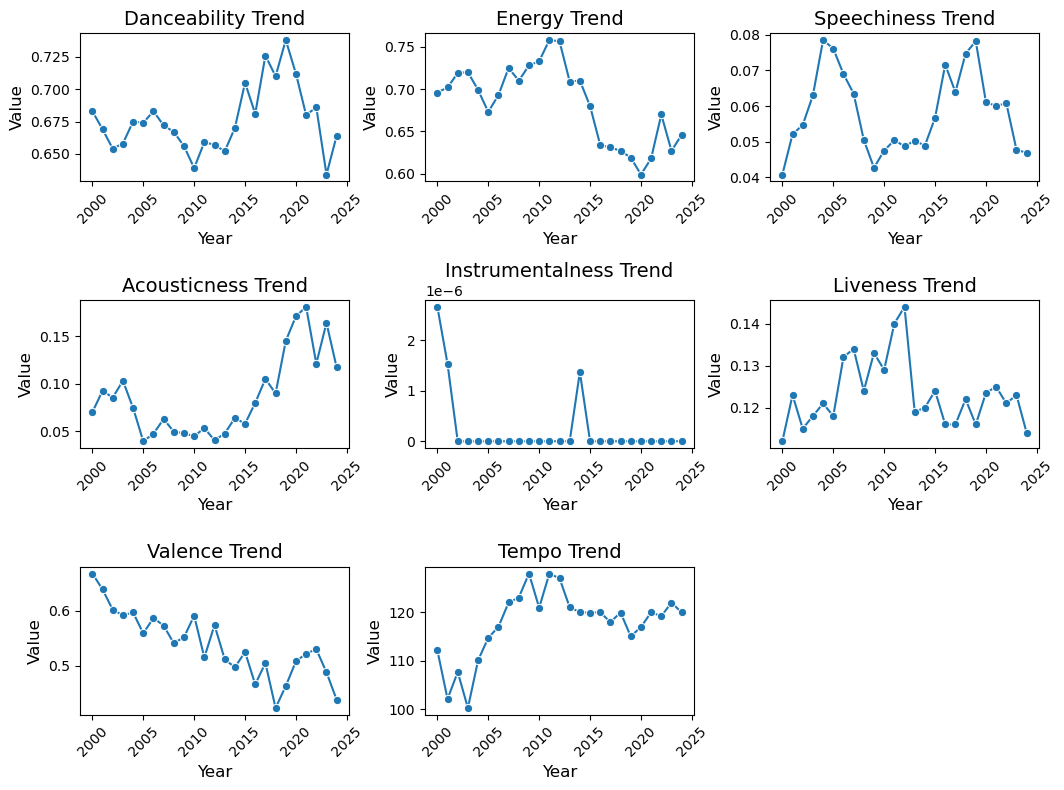

In [824]:
yearly_trends = yearly_trends.sort_values(by='chart_year')

features = ['danceability', 'energy', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo']

# I wanted the graphs smaller since there are so many
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10.5, 8)) 
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.lineplot(data=yearly_trends, x='chart_year', y=feature, ax=axes[i], marker='o')
    axes[i].set_title(f'{feature.capitalize()} Trend', fontsize=14)
    axes[i].set_xlabel('Year', fontsize=12) # Note, 2025 is shown as a label bc it's every 5 years, but the data ends at 2024
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Turn off the extra subplot (last one, which has no data)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

### The Stock Market Over the Same Time, Measured Using the S&P 500 Index

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   931800000
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000


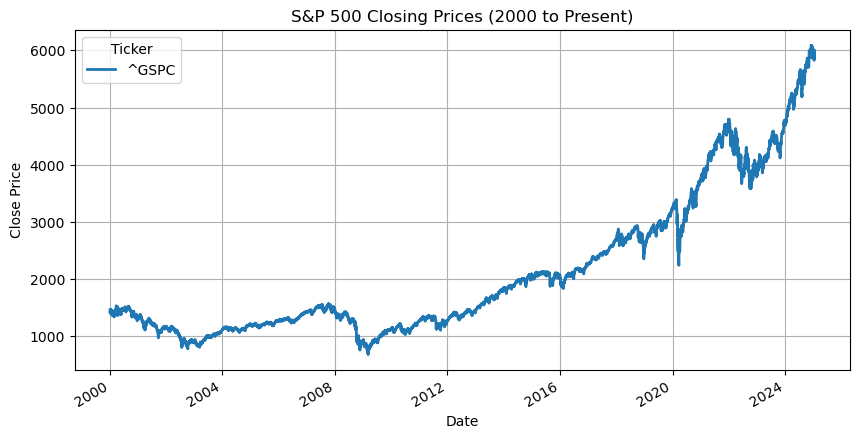

In [331]:
sp500_ticker = '^GSPC'

# Download the historical data from 2000 to today
sp500_data = yf.download(sp500_ticker, start='2000-01-01', end=None)

# Display the first few rows of the data
print(sp500_data.head())

# Plot the closing price of the S&P 500
sp500_data['Close'].plot(figsize=(10, 5), title='S&P 500 Closing Prices (2000 to Present)', lw=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

### GDP Over Time

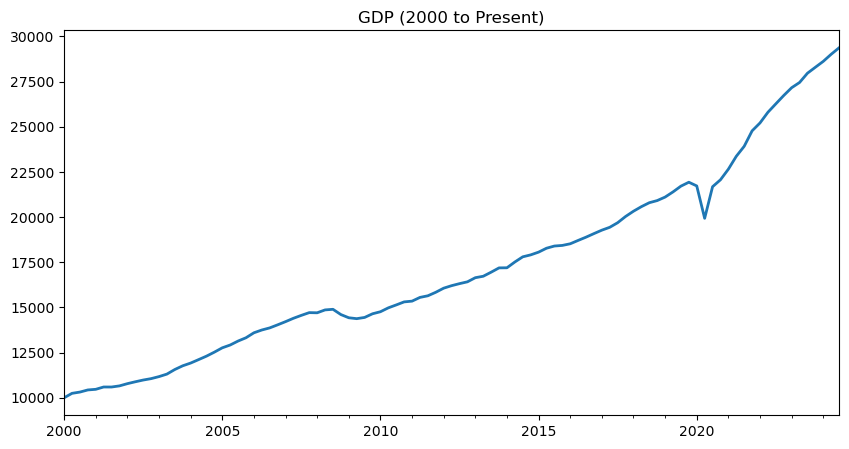

In [322]:
gdp = fred.get_series(series_id='GDP')
gdp = gdp[gdp.index >= '2000-01-01']

gdp.plot(figsize=(10, 5), title='GDP (2000 to Present)', lw=2)
plt.show()

### Unemployment Rate Over Time

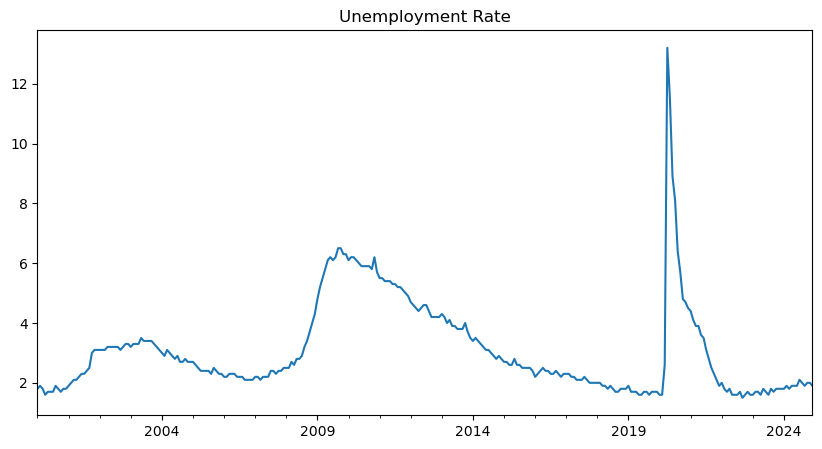

In [333]:
unemp = fred.get_series(series_id='U2RATE')
unemp = unemp[unemp.index >= '2000-01-01']
unemp.plot(figsize=(10,5), title='Unemployment Rate')
plt.show()

#### Summary

#### Danceability hit a bottom in the year 2010, which coincides with the spike in the unemployment rate.

There are also some trends around the year 2020 that could have possibly been hastened or exaggerated by the pandemic, which, as we can see from the graphs, had a big impact on the economy, but it's impossible to infer with the amount of data here. I will look further into a possible correlation to the pandemic later.

### Did the Great Recession have an impact?

We've already seen a potential relationship between danceability and a couple of negative economic indicators during the Great Recession. Is there more?

To further look into whether the Great Recession influenced musical preferences, I'll make a comparison of the music that was charting during that time to the period immediately before. 
Since the Great Recession lasted 19 months, the duration of the pre-recession timeframe will be 19 months as well.

#### A Look At Variation During Different Economic Realities

First, I want to see how much variation exists in the music of each timeframe so I'll calculate the variance of the columns of interest.
This is already interesting - do people listen to a broader or narrower variety of music during different economic cycles? Furthermore, it allows me to determine if the mean or median is more apt for further analysis of audio features.

In [516]:
"""
I need to make 2 timeframes: before the recession and during. 
I'll do this by creating a dictionary with keys to store the values I want.
Next I'll create the cols list of columns I'm interested.
Then I'll make an empty dict and a for loop to check in each timeframe - I'll filter the data 
to the show only chart weeks in those timeframes, then calculate the variance by 
iterating through the columns that contain enough data, and dropping those that don't.
"""


# 19 month timeframes
chart_timeframes = {
    "May 2006 - Nov 2007": ("2006-05-01", "2007-11-30"),
    "Dec 2007 - Jun 2009": ("2007-12-01", "2009-06-30"),
}

cols = [
    'danceability', 'energy', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]


variance_results = {}

for timeframe, (start_date, end_date) in chart_timeframes.items():
    timeframe_data = songs[(songs['chart_week'] >= start_date) & (songs['chart_week'] <= end_date)]
    
    variance_values = {col: variance(timeframe_data[col].dropna()) for col in cols if len(timeframe_data[col].dropna()) > 1}
    
    variance_results[timeframe] = variance_values

variance_df = pd.DataFrame(variance_results).T

print(variance_df)

                     danceability    energy  speechiness  acousticness  \
May 2006 - Nov 2007      0.022822  0.025780     0.009952      0.029829   
Dec 2007 - Jun 2009      0.018815  0.023361     0.006311      0.034391   

                     instrumentalness  liveness   valence       tempo  
May 2006 - Nov 2007          0.006755  0.016828  0.045764  915.062820  
Dec 2007 - Jun 2009          0.016583  0.019767  0.046467  818.267521  


#### A Look at the Means and Medians

I eliminated the categories that showed uninteresting results.

In [794]:
# Means

af_avgs = {}
for label, (start, end) in chart_timeframes.items():
    timeframe_data = songs[(songs['chart_week'] >= start) & (songs['chart_week'] <= end)]
    af_avgs[label] = timeframe_data[
        ['danceability', 'energy', 'speechiness',
         'valence', 'tempo']
    ].mean()

af_avgs_df = pd.DataFrame(af_avgs).T
af_avgs_df

,danceability,energy,speechiness,valence,tempo
May 2006 - Nov 2007,0.630239,0.713852,0.098728,0.549203,122.491060
Dec 2007 - Jun 2009,0.617936,0.712727,0.077756,0.524902,125.657264


In [796]:
# Medians

af_median = {}
for label, (start, end) in chart_timeframes.items():
    timeframe_data = songs[(songs['chart_week'] >= start) & (songs['chart_week'] <= end)]
    af_median[label] = timeframe_data[
        ['danceability', 'energy', 'speechiness', 
         'valence', 'tempo']
    ].median()

af_median_df = pd.DataFrame(af_median).T
af_median_df

,danceability,energy,speechiness,valence,tempo
May 2006 - Nov 2007,0.626,0.738,0.0521,0.562,120.997
Dec 2007 - Jun 2009,0.629,0.725,0.0457,0.522,126.050


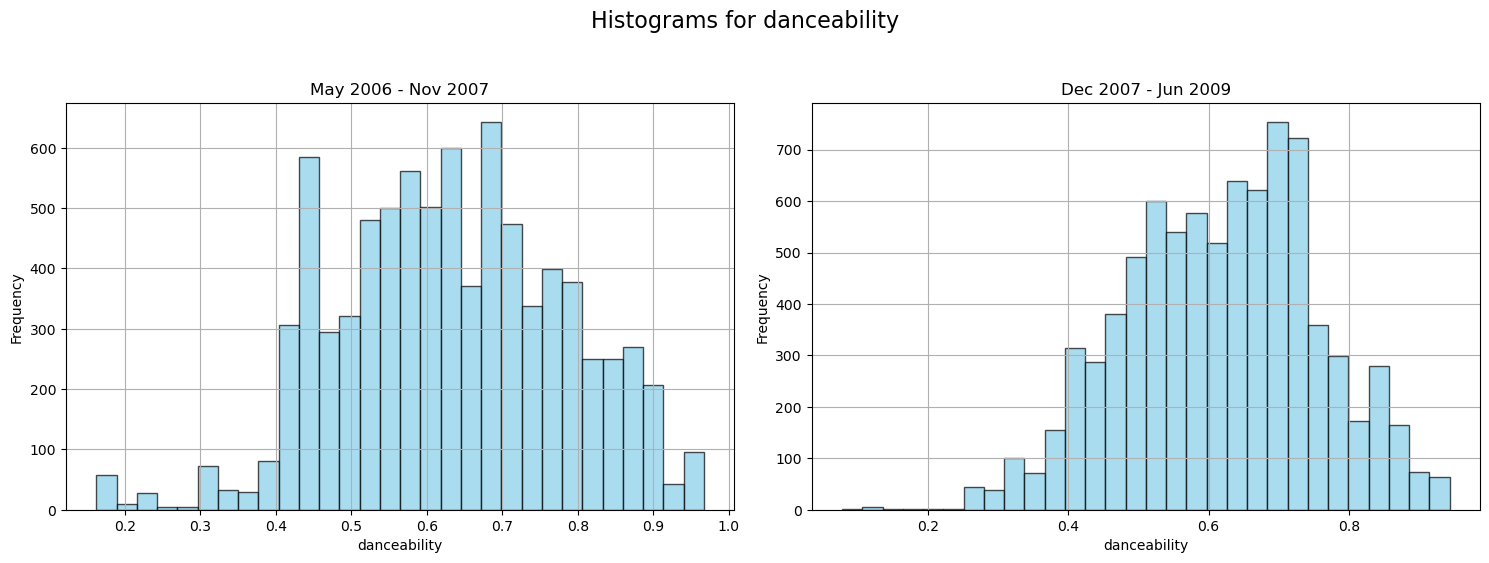

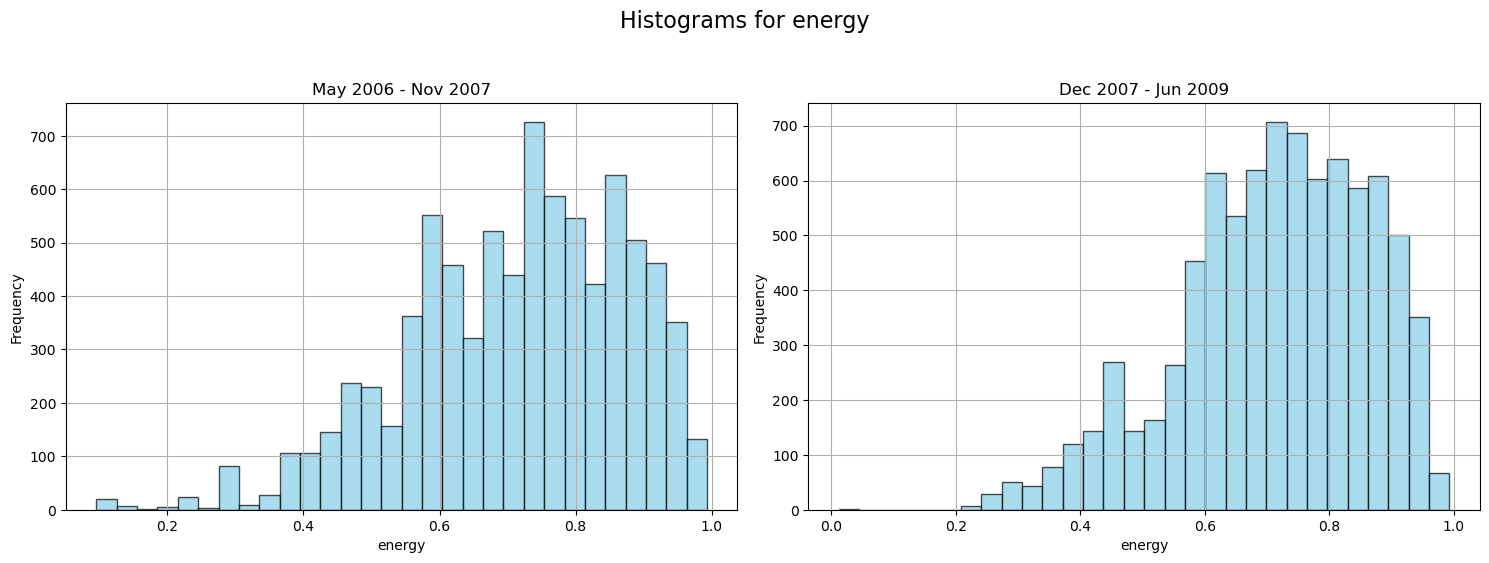

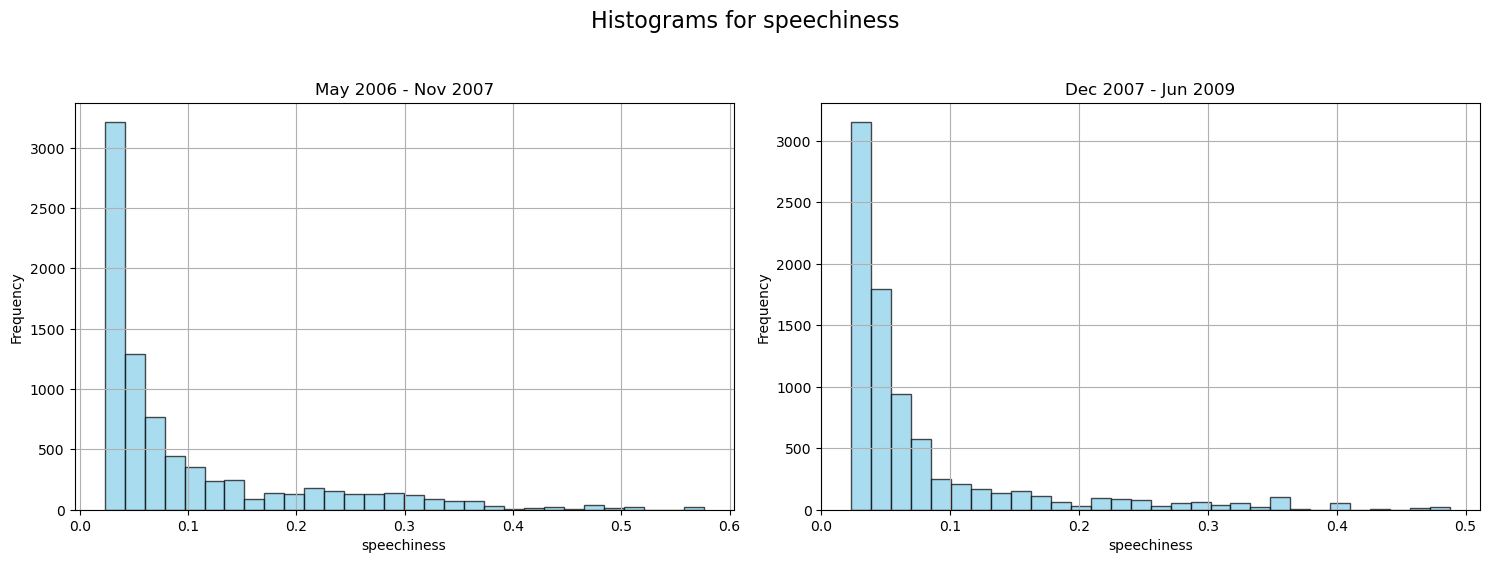

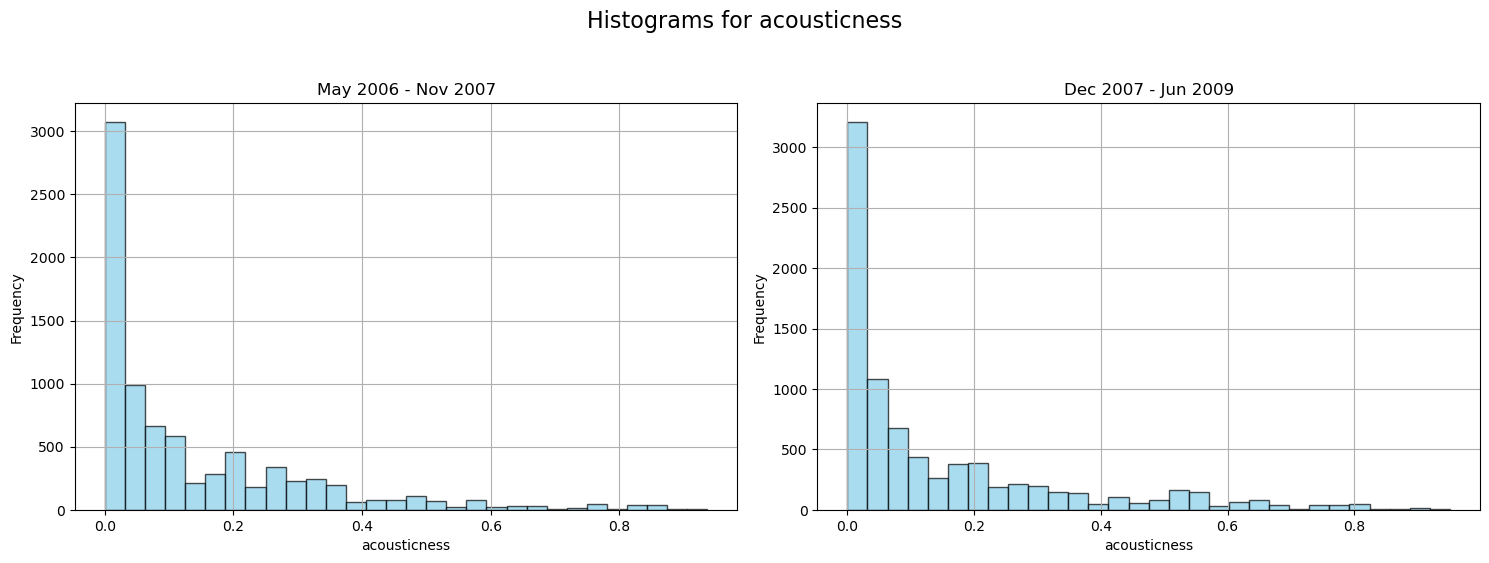

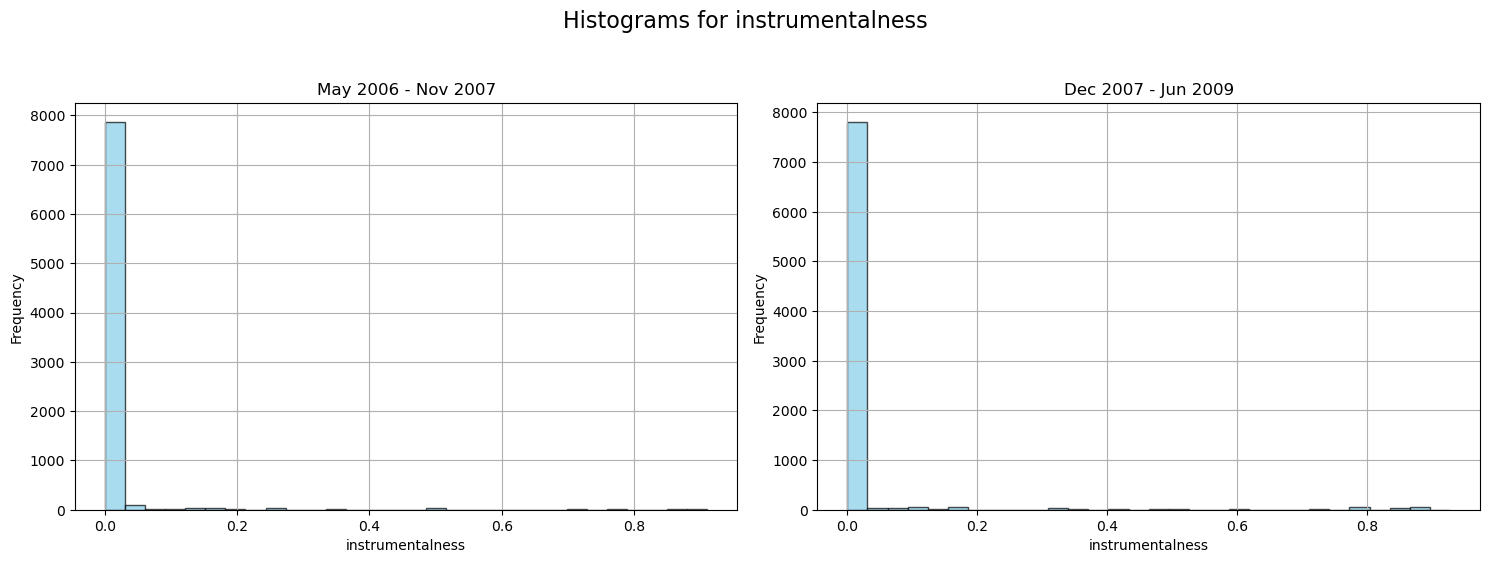

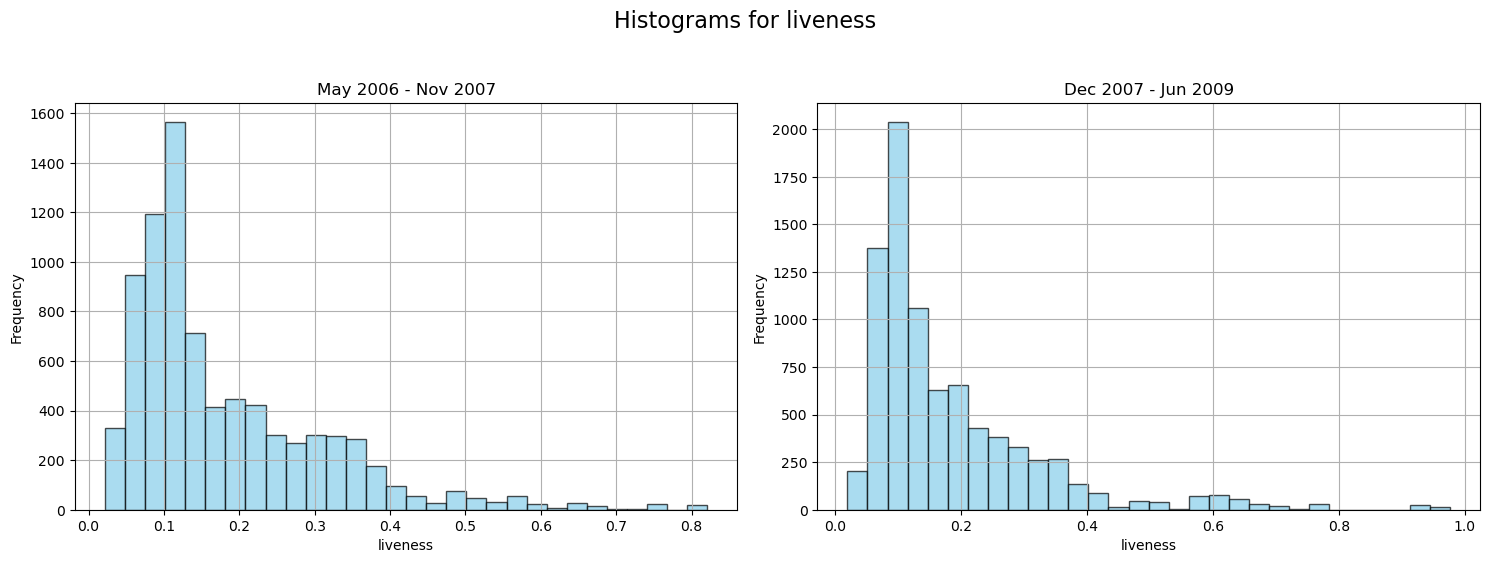

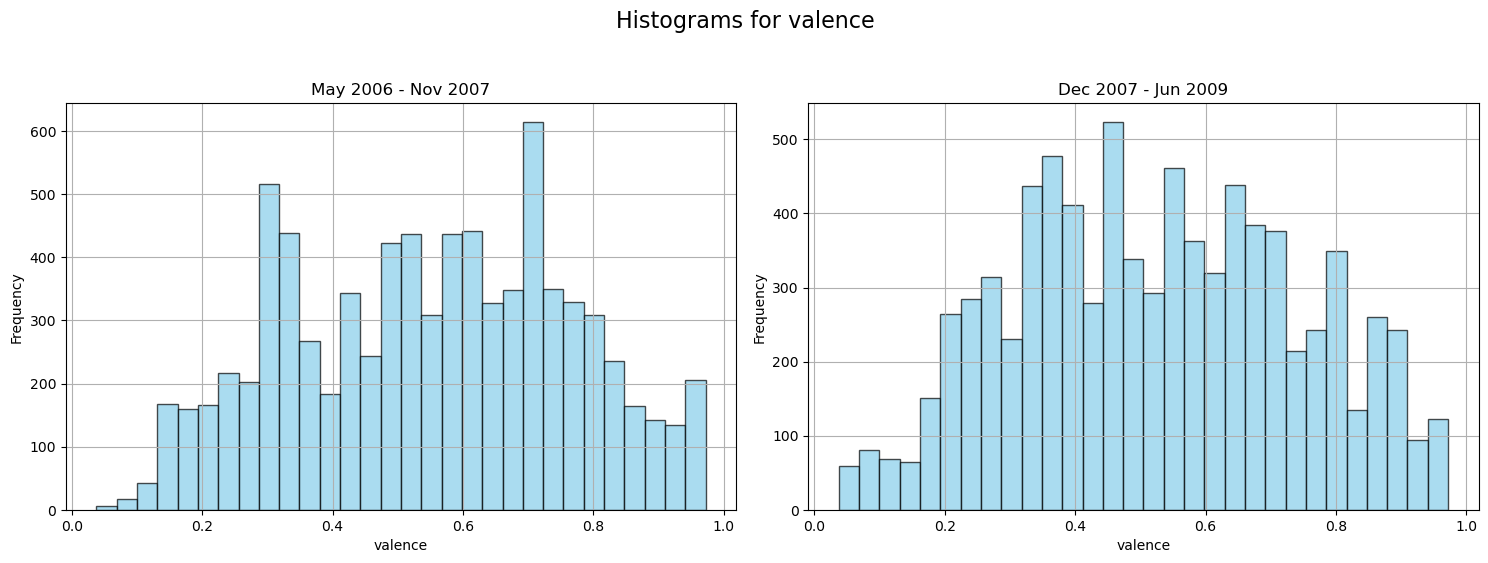

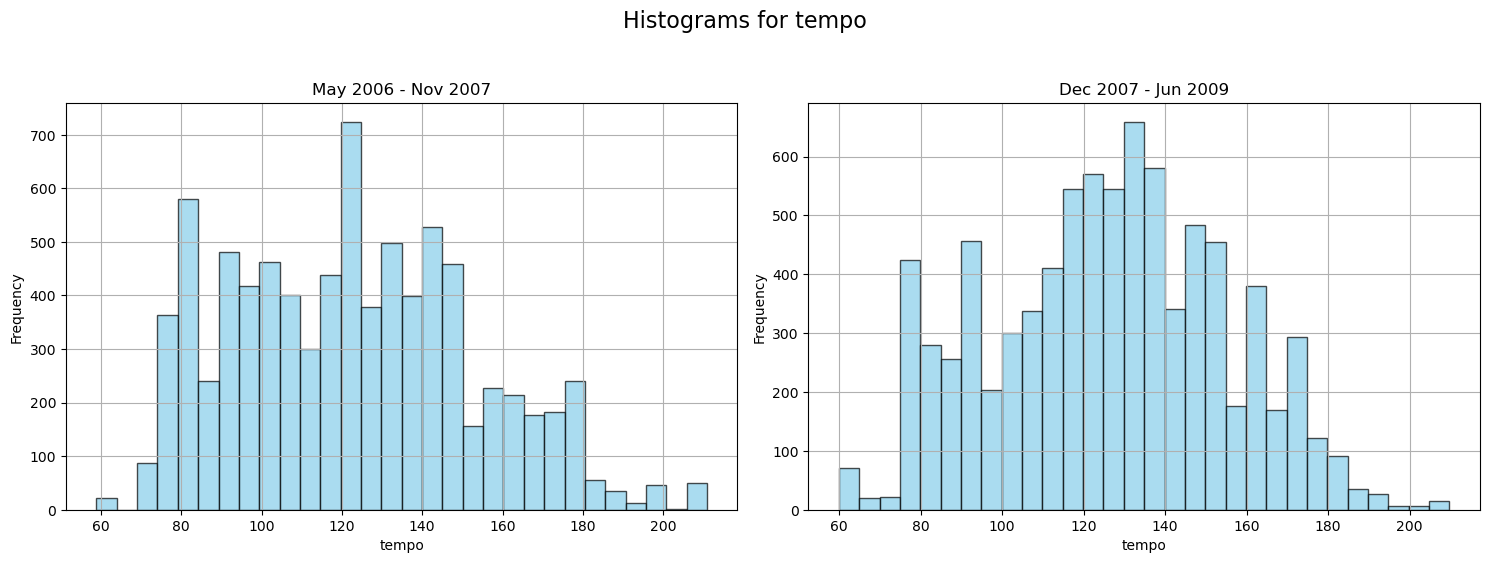

In [636]:
"""
I want to know the distribution to see what skew or outliers we have.
I'm making a function to create histograms for each audio feature for each timeframe.
"""

def histograms(df, columns, timeframes):
        
    for column in columns:
        plt.figure(figsize=(15, 10))
        plt.suptitle(f'Histograms for {column}', fontsize=16)
        
        for i, (timeframe, (start_date, end_date)) in enumerate(timeframes.items(), start=1):

            timeframe_data = df[(df['chart_week'] >= start_date) & (df['chart_week'] <= end_date)]
            
            plt.subplot(2, 2, i)  
            timeframe_data[column].hist(bins=30, color='skyblue', edgecolor='black', alpha=0.7)
            plt.title(f'{timeframe}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96]) 
        plt.show()

histograms(songs, cols, chart_timeframes)

#### Charting Audio Features By Economic Health

After looking at the histograms, it doesn't seem like speechiness, acousticness, instrumentalness, and liveness are greatly affected.
I'll focus on the other five columns.

- **Danceability:**
Variance decreased by about 17% during the Great Recession. Preferences clustered on a slightly higher danceability score (when looking at the median).
(Note: as seen in previous graphs, danceability does go down in 2010, when the effects of the Great Recession culminate in a spike in unemployment and )

- **Energy:**
Variance decreased about 9% but the energy level remained relatively unchanged.
  
- **Speechiness:**
Variance dropped significantly - over 36%. The level of speechiness also dropped.

- **Valence:**
Variance was quite similar between both periods, with less than a 1.5% difference. The level of valence dropped slightly.

- **Tempo:**
Variance dropped almost 11% and the level increased 2.6%.


#### Key Insights on the Impact of the Great Recession on Audio Features:

1.	Escapism and Positivity:
While danceability, energy, and tempo levels all increased slightly, valence decreased. In other words, music remained energetic and party-appropriate but became less explicitly cheerful. It's possible people tended towards using music as a release - still wanting music you could party to, but that didn't have a contrived cheeriness disconnected from reality.

2.	Shift away from Speechiness:
The drop in speechiness indicates a preference for music with fewer lyrics or spoken words. The overall feel of the music may have been more important than message.

## Did the Pandemic Affect the Chart?

A look at the trends of audio features of the hot 100 in the years before and after the start of the lockdown.

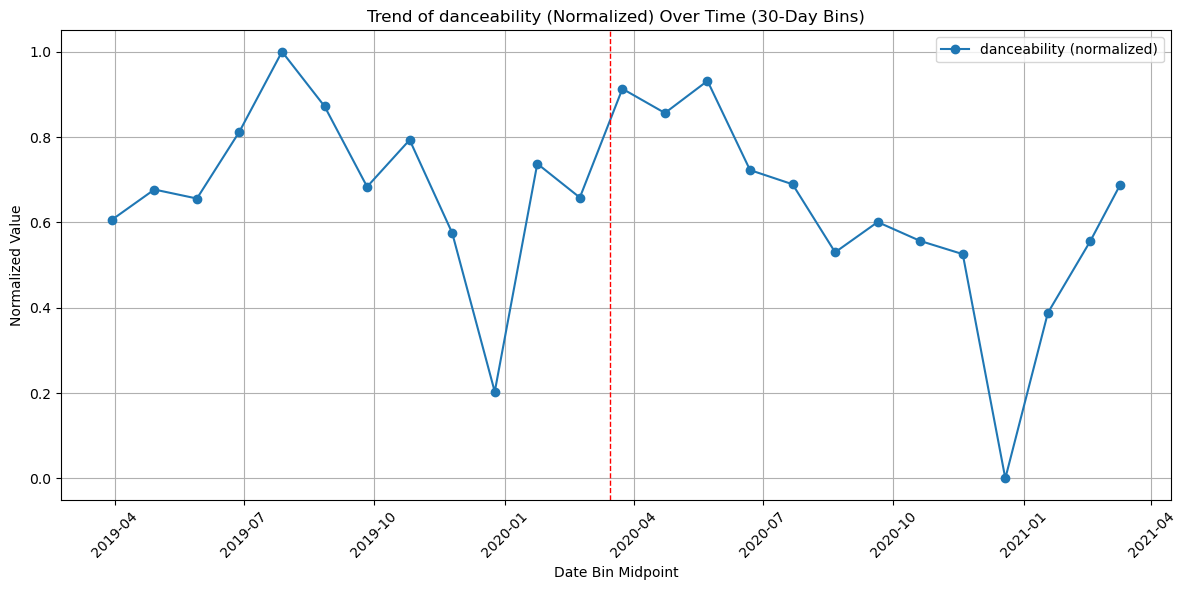

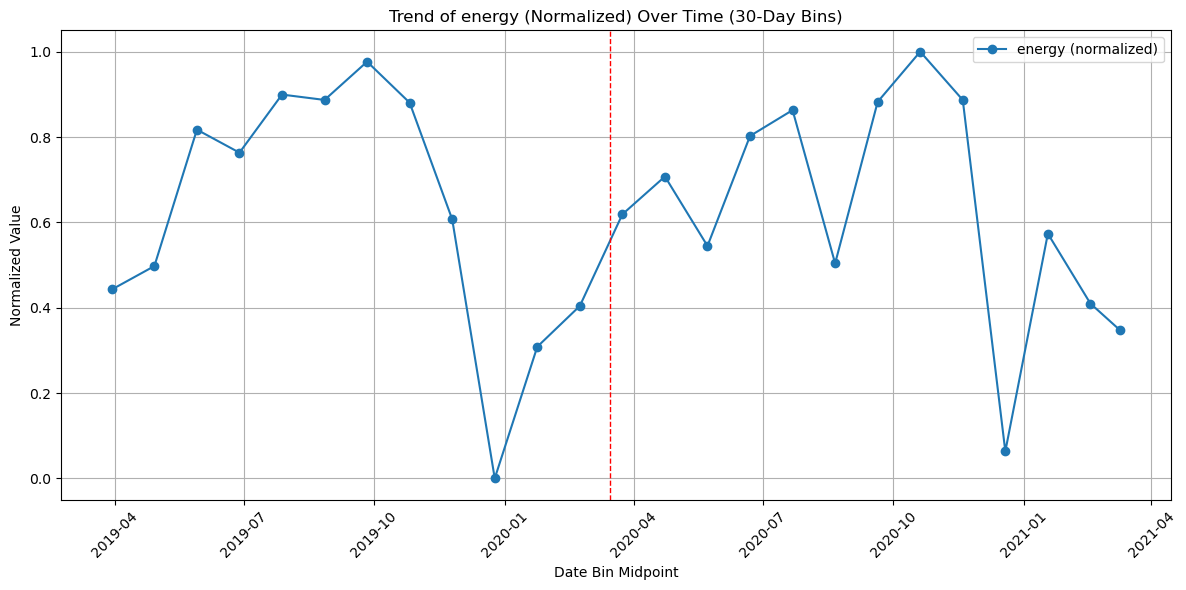

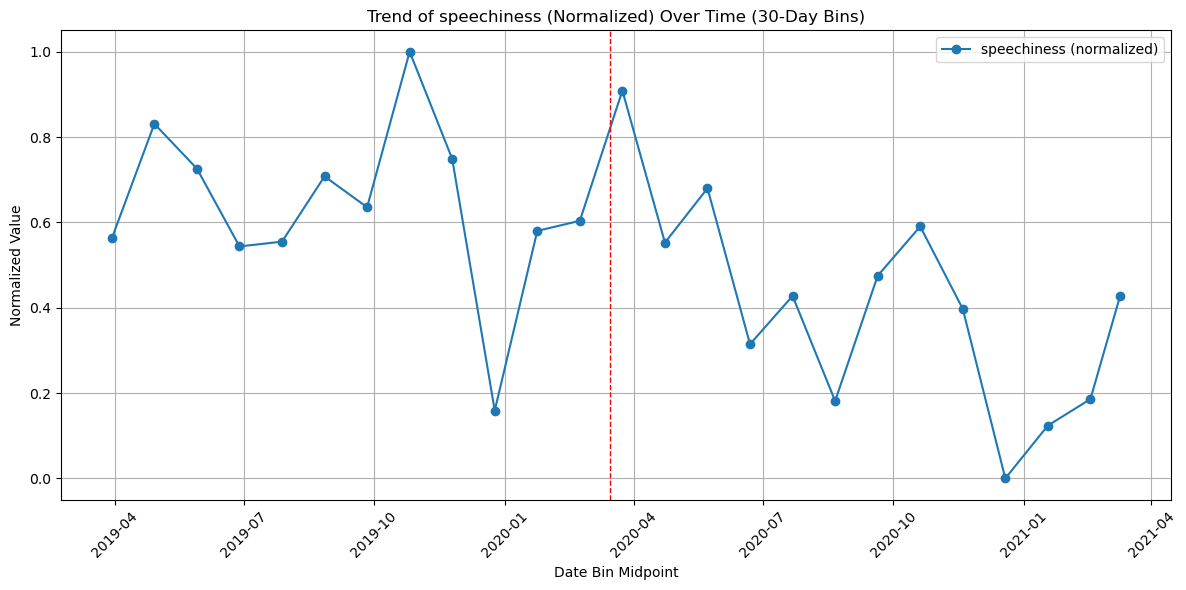

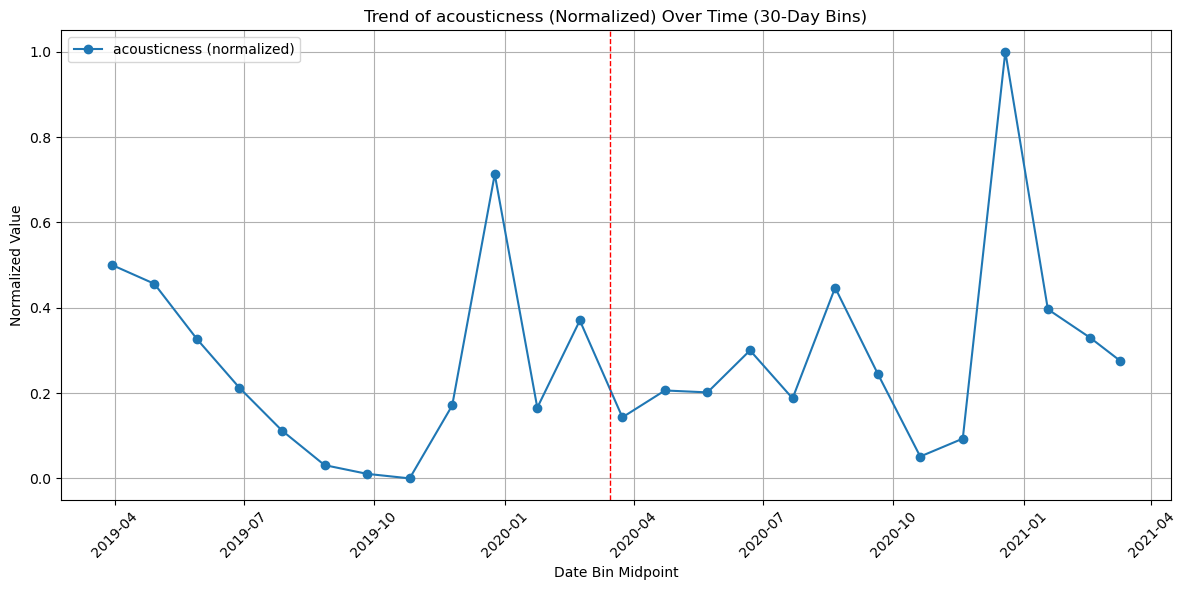

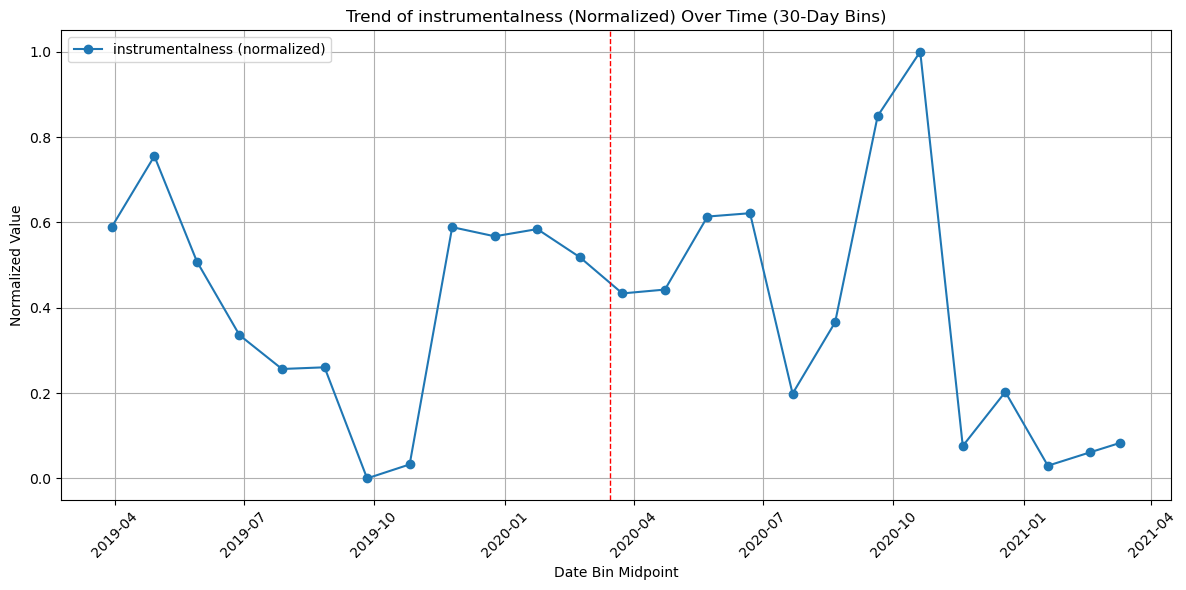

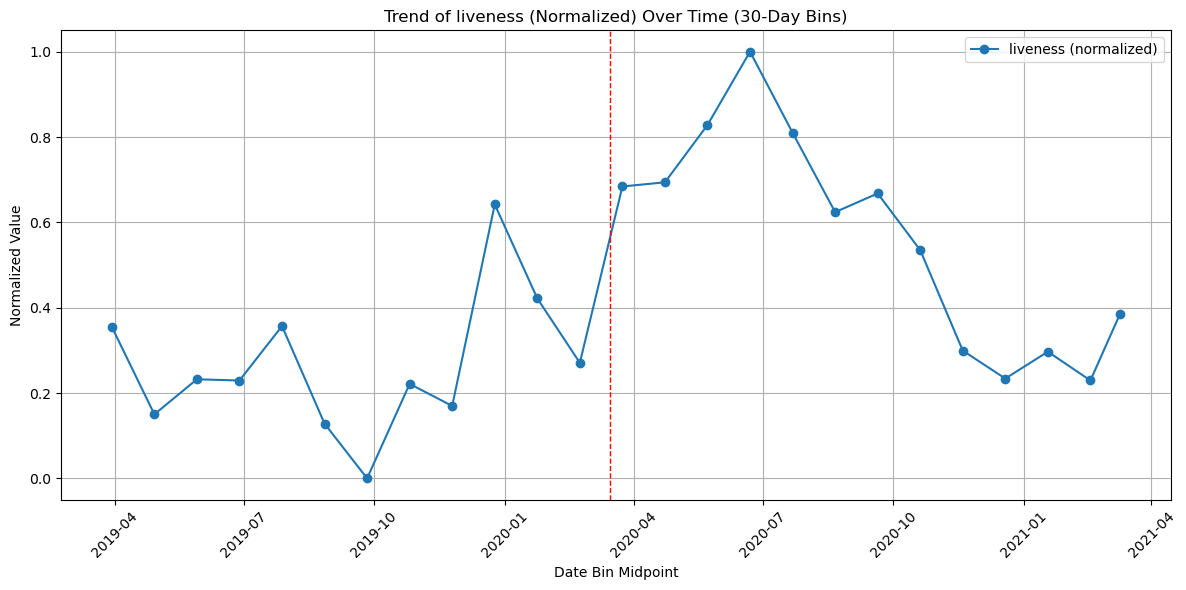

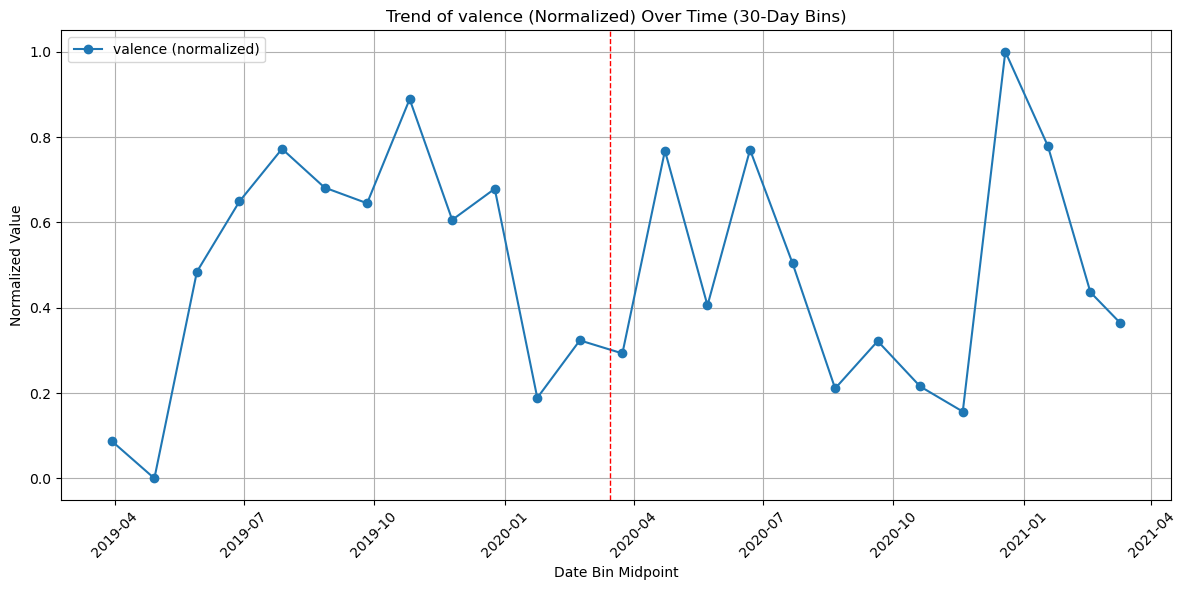

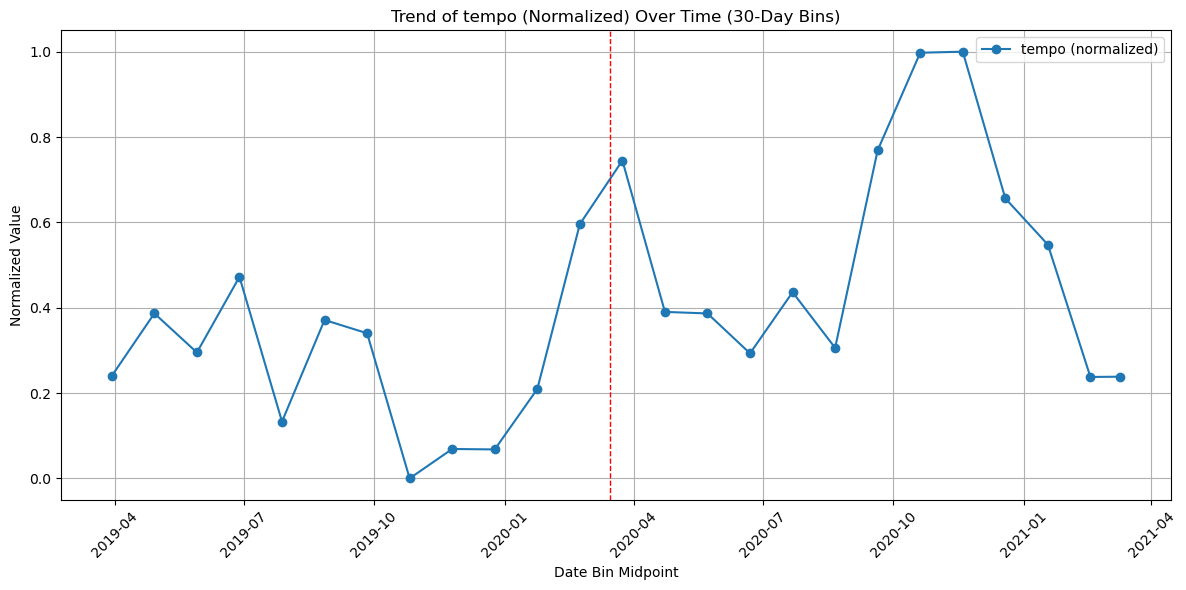

In [1069]:
audio_features = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Filter rows between March 15, 2019, and March 16, 2021
lockdown_ba = songs[
    (songs['chart_week'] >= '2019-03-15') & (songs['chart_week'] <= '2021-03-16')
]

start_date = pd.Timestamp('2019-03-15')
end_date = pd.Timestamp('2021-03-16')  # Set the last date to March 16, 2021

# Define bin edges and labels
bin_edges = pd.date_range(start=start_date, end=end_date, freq='30D').append(pd.DatetimeIndex([end_date]))
bin_labels = [f"{bin_edges[i].strftime('%b %d, %Y')} - {bin_edges[i + 1].strftime('%b %d, %Y')}" 
              for i in range(len(bin_edges) - 1)]

lockdown_ba['30_day_bin'] = pd.cut(lockdown_ba['chart_week'], bins=bin_edges, labels=bin_labels, right=False)

# Group by the 30-day bins and calculate mean for each audio feature
binned_means = lockdown_ba.groupby('30_day_bin')[audio_features].mean()

# Convert the index to a format usable for plotting (midpoint of bins)
binned_means['bin_midpoint'] = [
    bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2 for i in range(len(bin_edges) - 1)
]
binned_means.set_index('bin_midpoint', inplace=True)

# Normalize each feature to the range [0, 1]
binned_means_normalized = binned_means[audio_features].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Define the lockdown date
lockdown_date = pd.Timestamp('2020-03-15')

# Create a plot for each audio feature
for feature in audio_features:
    plt.figure(figsize=(12, 6))
    
    # Plot the normalized trend so the graphs are uniform and easy to read
    plt.plot(binned_means.index, binned_means_normalized[feature], marker='o', label=f"{feature} (normalized)")
    
    # Highlight March 15, 2020 with a vertical line only (adding a label was too messy)
    plt.axvline(x=lockdown_date, color='red', linestyle='--', linewidth=1) 
    
    plt.title(f"Trend of {feature} (Normalized) Over Time (30-Day Bins)")
    plt.xlabel("Date Bin Midpoint")
    plt.ylabel("Normalized Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

### There doesn't seem to be an impact

While there are big changes around that date that lockdowns began in the US (2020-03-15), for a couple of the audio features, they are not in isolation so they can't be assumed to be meaningful. I suspect that people just kept listening to what was already popular and that perhaps any influence the effects may have had on music would have taken longer to show up (for example, charting music tends to be the newest music and any music written as a result of the pandemic would take time to be produced and released.)

## We've Been Getting Angrier Over Time - Does This Reflect in the Charts? 
### Cuss and Effect: Tracking Trends in Explicit Content

In [347]:
songs['year'] = songs['chart_week'].dt.year

explicit_counts = songs.groupby(['year', 'explicit']).size().unstack(fill_value=0)

In [838]:
# Calculate explicit counts as a percentage of all songs for each year
explicit_perc = (explicit_counts.div(explicit_counts.sum(axis=1), axis=0)) * 100

#explicit_perc 

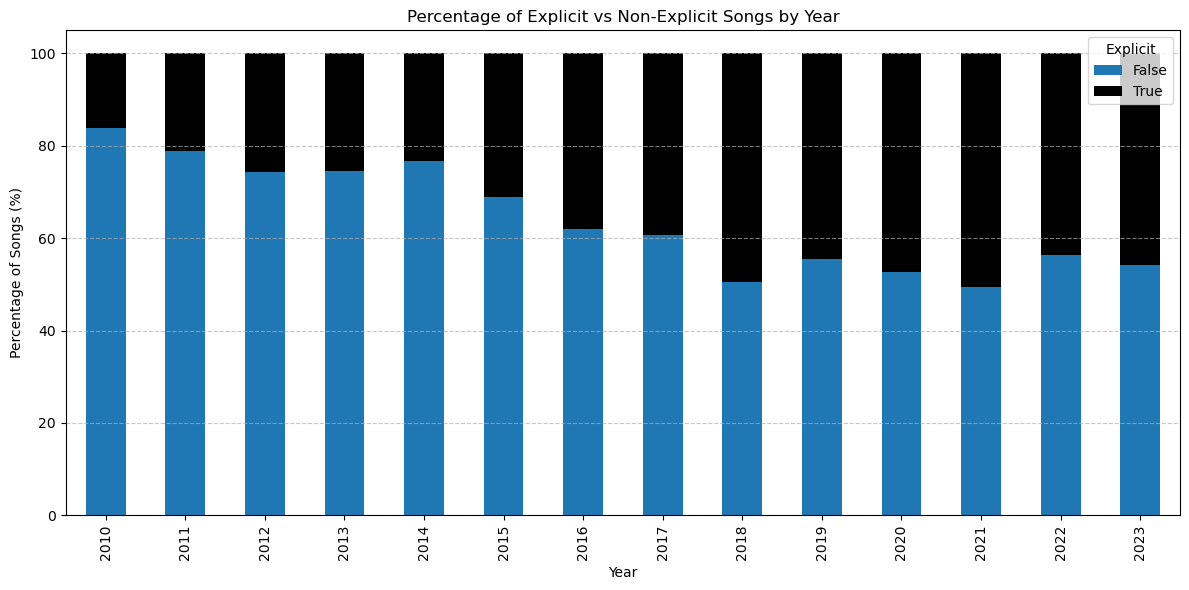

In [607]:
"""
I changed the colors so the non-explicit would remain the same blue, since it's 
inoffensive and the explicit is black because that's the color on the explicit warning label.

I filtered the years to only capture the years in the World Happiness Graph, minus 2024 since only
41 weeks are in the dataset.

I used a stacked bar graph showing percentages
"""

explicit_perc_filtered = explicit_perc[(explicit_perc.index >= 2010) & (explicit_perc.index <= 2023)]

explicit_perc_filtered.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    title='Percentage of Explicit vs Non-Explicit Songs by Year',
    color=['#1f77b4', 'black']
)

plt.xlabel('Year')
plt.ylabel('Percentage of Songs (%)')
plt.legend(title='Explicit')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### The image below shows the **3-Year Average** Life Satisfaction of Americans
Since it's a three-year average as opposed to yearly, the trending results will be smoother 
and will lag, but note that the noticeable dips show up after the most explicit years.

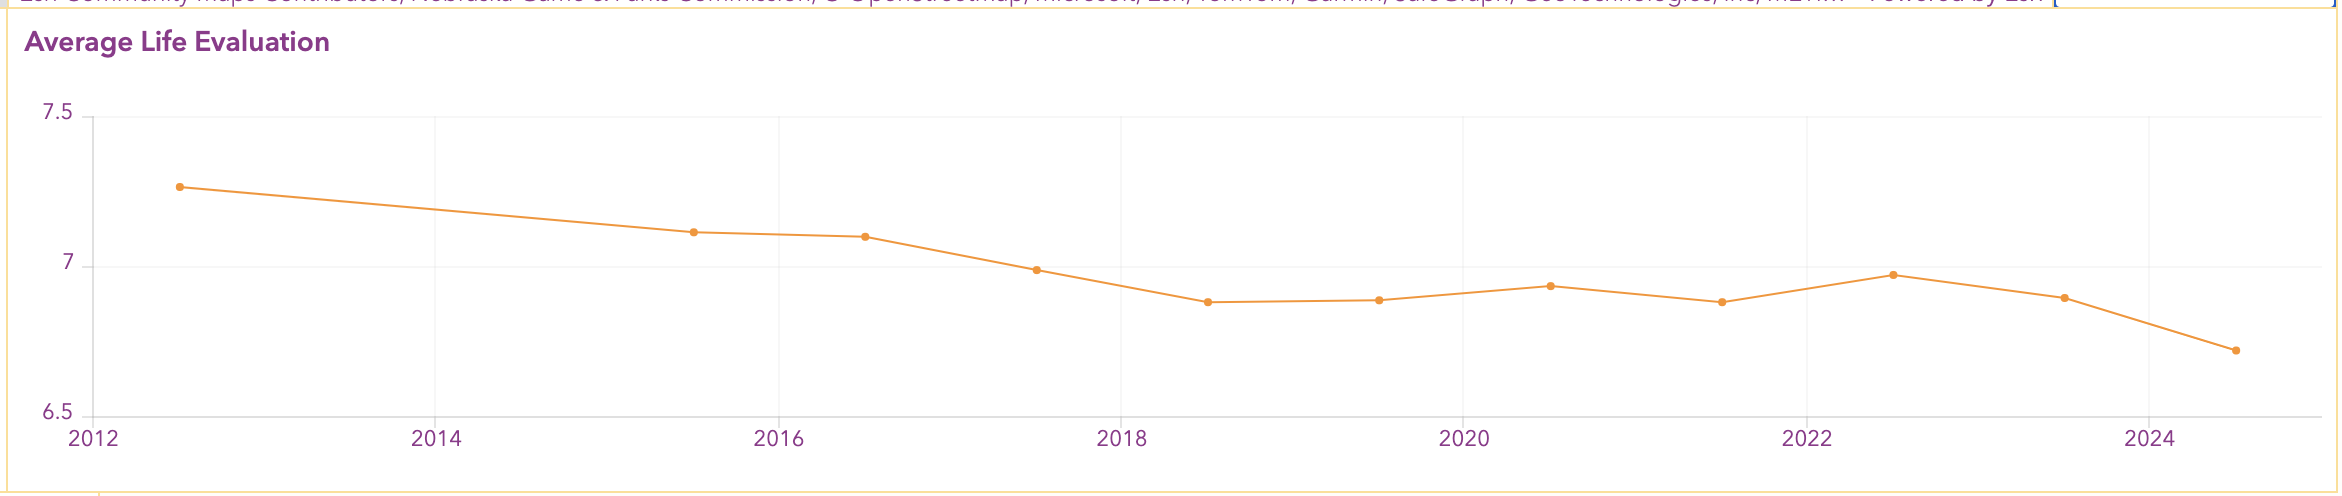

Source URL: https://worldhappiness.report/data/
Dashboard and Maps: SDSN SDGs Today. World Happiness Report. Data sourced from SDSN. UN Sustainable Development Solutions Network. Accessed 2024-01-21.

### Music Preferences Are Getting More Explicit

Possible explanations:

#### 1. Decreased Life Satisfaction.
- **Americans are increasingly angry and stressed**, according to the World Happiness Report. It could be that listeners are more likely to choose explicit content when feeling these emotions more frequently. Another confounding factor could be that our higher levels of social media use, which are positively correlated (1) to feelings of anger and stress, are exposing us to more explicit content and therefore normalizing it.

#### 2. Shift in the Political Landscape.
- The beginning of the relatively dramatic increase coincides with the lead-up to the **2016 presidential election**, which led to a dramatic shift to the conservative right. Perhaps the trend can be partially explained by anger and as a **pushback to conservative morals**, for example: did the political climate lead to a rise in the output of this type of music, and did the negative attention from conservatives received by Cardi B for the song WAP lead to a further increase in demand for this song and others like it? Interestingly, Google Trends shows that of the 5 states that topping Google searches for that song, 4 of the 5 are socially conservative red states.

(1) Source: "Irritability and Social Media Use in US Adults", published 8 Jan 2025. Roy H. Perlis, MD, et al.
Accessed via jamanetwork.com

## Gender Roles

There has been a lot of discussion surrounding gender identity and gender equality in recent years. Here I will explore if there's a relationship between feminist issues and music.

Two key events to look at:
1. The #MeToo Movement that gained traction in 2017.
2. The overturning of Roe v. Wade by the US Supreme Court, reversing the constititional right to an abortion.

### Notes on this code and the time it takes to run:

The original dataset is too large to iterate this function through each artist so I'm limiting to Top 10 list positions and doing this in batchs starting with number 1's only to test, then a batch of 2-5 and then 6-10. MusicBrainz API only allows 1 request per second so running this code is slow.

Please note that running the code for number 1's takes almost 6 minutes to run.

In [681]:
"""
First, I need to merge the artist table to the mapping table.
Then, I need to group by track_id and aggregate the arists."""

merged_data = tracks_artists.merge(artists, on='artist_id', how='left')

singer_track = merged_data.groupby('track_id').agg({
    'artist_name': lambda x: ', '.join(str(val) for val in x if pd.notna(val))  # Convert to str and skip NaN
}).reset_index()

print(singer_track)

                     track_id                  artist_name
0      000TJlEJQ3nafsm1hBWpoj  42 Dugg, Tyler, The Creator
1      003FTlCpBTM4eSqYSWPv4H     The All-American Rejects
2      003vvx7Niy0yvhvHt4a68B                  The Killers
3      005lwxGU1tms6HGELIcUv9                   Katy Perry
4      009ImBOrIUlWgla8U05RAC                   Katy Perry
...                       ...                          ...
10779  7zo8XAMYBG6nGpqGiIudBc                     Don Omar
10780  7zqM7Wm2xJLZ50qAnTLoHD             Jazmine Sullivan
10781  7zuyvFHg8DcR9B1xtBfd4D                DJ Cover This
10782  7zywdG4ysfC5XNBzjQAo2o            Montgomery Gentry
10783                track_id                             

[10784 rows x 2 columns]


In [1126]:
"""
I want only the highest position on the chart for each song.
"""
# first step
highest_lp = songs.loc[songs.groupby('track_id')['list_position'].idxmin()]

highest_lp = highest_lp.reset_index(drop=True)

# print(highest_lp)

In [747]:
highest_lp.track_id.nunique()

10783

In [695]:
# Triple checking that my numbers are correct before continuing
list_position_counts = songs.groupby('track_id')['list_position'].count().reset_index()

list_position_counts.rename(columns={'list_position': 'list_position_count'}, inplace=True)

print(list_position_counts)

                     track_id  list_position_count
0      000TJlEJQ3nafsm1hBWpoj                    1
1      003FTlCpBTM4eSqYSWPv4H                   11
2      003vvx7Niy0yvhvHt4a68B                   38
3      005lwxGU1tms6HGELIcUv9                   23
4      009ImBOrIUlWgla8U05RAC                   20
...                       ...                  ...
10778  7zmqbdEqmQWgU2wOoBPG83                   20
10779  7zo8XAMYBG6nGpqGiIudBc                    4
10780  7zqM7Wm2xJLZ50qAnTLoHD                    8
10781  7zuyvFHg8DcR9B1xtBfd4D                   11
10782  7zywdG4ysfC5XNBzjQAo2o                   20

[10783 rows x 2 columns]


In [759]:
merged_data = tracks_artists.merge(artists, on='artist_id', how='left')

tracks_with_artists = merged_data.merge(songs, on='track_id', how='inner')

artist_highest_lp = tracks_with_artists.loc[songs.groupby('track_id')['list_position'].idxmin()]

artist_highest_lp = artist_highest_lp.reset_index(drop=True)

print(artist_highest_lp)

                    artist_id                track_id          artist_name  \
0      5y2Xq6xcjJb2jVM54GHK3t  051NZ3rr3HXTULCEySJRX3          John Legend   
1      0du5cEVh5yTK9QJze8zA0C  32OlwWuMpZ6b0aN2RZOeMS           Bruno Mars   
2      06HL4z0CvFAxyc27GXpf02  6wn61Fzx9XMxQmieLpoIhW         Taylor Swift   
3      1Xfmvd48oOhEWkscWyEbh9  5Y77SQxEr1eiofPeUTPHxM                Lloyd   
4      2XnnxQzxFZG8qEPjakokPM  6uzesxG4dlBg3faZmzL6Qs           Obie Trice   
...                       ...                     ...                  ...   
10778  1Zatb2YN4erBOoSivOXc0o  376KnY4TrgBITxjlnbnmIy         O.T. Genasis   
10779  181bsRPaVXVlUKXrxwZfHK  79AHPJd8upvNxyK2qQcY8J  Megan Thee Stallion   
10780  1Xyo4u8uXC1ZmMpatF05PJ  00Blm7zeNqgYLPtW6zg8cj           The Weeknd   
10781  1wLeBWSGyI3mnTeiDAcgjP  5n3HwrDGRlUT7SrJCWM4yf  Ashley Parker Angel   
10782  0u2FHSq3ln94y5Q57xazwf  7MtZJEuIZ6GEKGSN7ttTkX          Keith Urban   

       popularity  followers                       track_name r

In [782]:
number_1s = artist_highest_lp[(artist_highest_lp['list_position'] == 1)]

In [914]:
two_five = artist_highest_lp[(artist_highest_lp['list_position'] >= 2) & (artist_highest_lp['list_position'] <= 5)]

In [916]:
two_five.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 5 to 10774
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   artist_id         462 non-null    object        
 1   track_id          462 non-null    object        
 2   artist_name       462 non-null    object        
 3   popularity        462 non-null    Int64         
 4   followers         462 non-null    Int64         
 5   track_name        462 non-null    object        
 6   release_date      462 non-null    datetime64[ns]
 7   explicit          462 non-null    boolean       
 8   danceability      462 non-null    float64       
 9   energy            462 non-null    float64       
 10  key               462 non-null    float64       
 11  loudness          462 non-null    float64       
 12  mode              462 non-null    float64       
 13  speechiness       462 non-null    float64       
 14  acousticness      462 non-nul

In [940]:
six_ten = artist_highest_lp[(artist_highest_lp['list_position'] >= 6) & (artist_highest_lp['list_position'] <= 10)]

In [729]:
mb.set_useragent(
    "AddGender",       
    "1.0",              
    "arielle.haslam@hyperisland.se"  
)

In [784]:
def get_artist_gender(artist_name):
    """
    Fetch the gender of the artists using the MusicBrainz API.
    """
    try:
        artist_name = artist_name.strip()
        
        result = mb.search_artists(artist=artist_name, limit=1)

        if result['artist-list']:
            artist = result['artist-list'][0]
            gender = artist.get('gender', 'Unknown')
            print(f"Gender for {artist_name}: {gender}")  # Debug print
            return gender
        else:
            print(f"Artist not found: {artist_name}")  # Debug print
            return 'Not Found'
    except Exception as e:
        print(f"Error fetching data for {artist_name}: {e}")
        return 'Error'
        

# Add gender column to the dataframe
genders = []
for name in number_1s['artist_name']:
    gender = get_artist_gender(name)
    genders.append(gender)
    time.sleep(1)  # To avoid rate limiting

number_1s['gender'] = genders

print(number_1s)

Gender for 21 Savage: male
Gender for Fat Joe: male
Gender for 50 Cent: male
Gender for The Chainsmokers: Unknown
Gender for Jack Harlow: male
Gender for JAY-Z: male
Gender for Drake: male
Gender for The Chainsmokers: Unknown
Gender for Olivia: female
Gender for Ryan Lewis: male
Gender for Billy Ray Cyrus: male
Gender for Ja Rule: male
Gender for Rihanna: female
Gender for USHER: male
Gender for Ariana Grande: female
Gender for Pharrell Williams: male
Gender for Olivia: female
Gender for Chance the Rapper: male
Gender for Pharrell Williams: male
Gender for USHER: male
Gender for 50 Cent: male
Gender for JAY-Z: male
Gender for JAY-Z: male
Gender for Static Major: male
Gender for Justin Bieber: male
Gender for Rihanna: female
Gender for Gotye: male
Gender for Drake: male
Gender for Justin Timberlake: male
Gender for Iggy Azalea: female
Gender for Ashanti: female
Gender for Ray Dalton: male
Gender for Ryan Lewis: male
Gender for Cardi B: female
Gender for Rihanna: female
Gender for Ariana

In [918]:
def get_artist_gender(artist_name):
    """
    Fetch the gender of the artists using the MusicBrainz API.
    """
    try:
        artist_name = artist_name.strip()
        
        result = mb.search_artists(artist=artist_name, limit=1)

        if result['artist-list']:
            artist = result['artist-list'][0]
            gender = artist.get('gender', 'Unknown')
            return gender
        else:
            return 'Not Found'
    except Exception as e:
        print(f"Error fetching data for {artist_name}: {e}")
        return 'Error'
        
genders = []
for name in two_five['artist_name']:
    gender = get_artist_gender(name)
    genders.append(gender)
    time.sleep(1)  # To avoid rate limiting

two_five['gender'] = genders

print(two_five)

                    artist_id                track_id     artist_name  \
5      5K4W6rqBFWDnAN6FQUkS6x  4OssqCixV2Xsxd43wMIQyS      Kanye West   
6      5pKCCKE2ajJHZ9KAiaK11H  4TsmezEQVSZNNPv5RJ65Ov         Rihanna   
29     0k7Xl1pqI3tu8sSEjo5oEg  0l7DPAKQVayEz9FXC9di2e       Paul Wall   
46     3TVXtAsR1Inumwj472S9r4  2SAqBLGA283SUiwJ3xOUVI           Drake   
89     5pKCCKE2ajJHZ9KAiaK11H  1z9kQ14XBSN0r2v6fx4IdG         Rihanna   
...                       ...                     ...             ...   
10655  64M6ah0SkkRsnPGtGiRAbb  4e4fqjx0Izh4svvTef1z7e      Bebe Rexha   
10735  4nDoRrQiYLoBzwC5BhVJzF  6v3KW9xbzN5yKLt9YKDYA2  Camila Cabello   
10743  5f7VJjfbwm532GiveGC0ZK  6ug9fUi5oLLgQgOF1G8WkM        Lil Baby   
10761  2mxe0TnaNL039ysAj51xPQ  5dNfHmqgr128gMY2tc5CeJ        R. Kelly   
10774  5pKCCKE2ajJHZ9KAiaK11H  1z9kQ14XBSN0r2v6fx4IdG         Rihanna   

       popularity  followers                                track_name  \
5              93   27515989                     

In [942]:
genders = []
for name in six_ten['artist_name']:
    gender = get_artist_gender(name)
    genders.append(gender)
    time.sleep(1)  # To avoid rate limiting

six_ten['gender'] = genders

print(six_ten)

                    artist_id                track_id         artist_name  \
34     5pKCCKE2ajJHZ9KAiaK11H  46MDLc0Yip6xCMSsdePOAU             Rihanna   
54     3sMYEBy0CZFxedcnm9i9hf  6Nq5lE0CeOAAAqN4qhkbZU           Frankie J   
67     04gDigrS5kc9YWfZHwBETP  6V1bu6o1Yo5ZXnsCJU8Ovk            Maroon 5   
103    1Wnfj5qZsp8nPsGBBRRa4W  1WoOzgvz6CgH4pX6a1RKGp               Monty   
113    2wIVse2owClT7go1WT98tk  5Y0E3dOeynKuLDAXu0t0Bg       Missy Elliott   
...                       ...                     ...                 ...   
10706  4TKTii6gnOnUXQHyuo9JaD  69j0KoPJuwpnbGWrfn7Yll         Sheryl Crow   
10711  5WUlDfRSoLAfcVSX1WnrxN  1NpW5kyvO4XrNJ3rnfcNy3                 Sia   
10715  1l7ZsJRRS8wlW3WfJfPfNS  0Hf4aIJpsN4Os2f0y0VqWl  Christina Aguilera   
10725  2mxe0TnaNL039ysAj51xPQ  1bl99Q4umnPomYGv3dQP67            R. Kelly   
10762  3Isy6kedDrgPYoTS1dazA9  6bK9BH9Ts8Gj5JFvnQkzak           Sean Paul   

       popularity  followers  \
34             92   63115308   
54         

In [1128]:
gender_top_10 = pd.concat([number_1s, two_five, six_ten], ignore_index=True) # adding it all back together

In [949]:
gender_top_10.sample(5)

,artist_id,track_id,artist_name,popularity,followers,track_name,release_date,explicit,danceability,energy,...,instrumentalness,liveness,valence,tempo,chart_week,list_position,release_year,chart_year,list_group,gender
517,5YGY8feqx7naU7z4HrwZM6,2vwlzO0Qp8kfEtzTsCXfyE,Miley Cyrus,84,24857826,Wrecking Ball,2013-10-04,False,0.530,0.422,...,0.000000,0.1070,0.349,119.964,2013-10-19,3,2013,2013,1-10,non-binary
342,64M6ah0SkkRsnPGtGiRAbb,4e4fqjx0Izh4svvTef1z7e,Bebe Rexha,81,9334209,Meant to Be (feat. Florida Georgia Line),2018-06-22,False,0.642,0.772,...,0.000000,0.0646,0.589,153.995,2018-05-05,4,2018,2018,1-10,female
668,46SHBwWsqBkxI7EeeBEQG7,0BkvZes677Mcp5WVUQjRxD,Kodak Black,82,11023914,ZEZE (feat. Travis Scott & Offset),2018-10-11,False,0.863,0.627,...,0.000003,0.0968,0.470,98.042,2018-11-17,8,2018,2018,1-10,male
44,2LIk90788K0zvyj2JJVwkJ,4xhsWYTOGcal8zt0J161CU,Jack Harlow,80,3940961,Lovin On Me,2023-11-10,True,0.943,0.558,...,0.000002,0.0937,0.606,104.983,2024-01-13,1,2023,2024,1-10,male
167,163tK9Wjr9P9DmM0AVK7lm,4SDWMFvYJKtK1QPhIOeZhd,Lorde,78,10062043,Royals,2013-03-08,False,0.674,0.426,...,0.000000,0.1320,0.337,84.876,2014-01-18,4,2013,2014,1-10,female


In [991]:
gender_top_10['gender'].value_counts()

gender
male              560
female            351
Unknown           202
non-binary         23
not applicable      3
Name: count, dtype: int64

In [993]:
non_binary_artists = gender_top_10[gender_top_10['gender'] == 'non-binary']
non_binary_artists['artist_name'].unique()

array(['Miley Cyrus', 'Sam Smith'], dtype=object)

In [1005]:
# only 2 artists are non-binary
# need to combine that and 'not applicable' to Unknown

# Replace specific values in the 'gender' column with "Unknown/Other"
gender_top_10['gender'] = gender_top_10['gender'].replace(
    ["Unknown", "non-binary", "not applicable"], "Unknown/Other"
)

gender_top_10['gender'].value_counts()

gender
male             560
female           351
Unknown/Other    228
Name: count, dtype: int64

In [1007]:
# so a new album drop by a popular artist won't skew the results
unique_top_10 = gender_top_10.drop_duplicates(subset='artist_id')

unique_top_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307 entries, 0 to 1134
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   artist_id         307 non-null    object        
 1   track_id          307 non-null    object        
 2   artist_name       307 non-null    object        
 3   popularity        307 non-null    Int64         
 4   followers         307 non-null    Int64         
 5   track_name        307 non-null    object        
 6   release_date      307 non-null    datetime64[ns]
 7   explicit          307 non-null    boolean       
 8   danceability      307 non-null    float64       
 9   energy            307 non-null    float64       
 10  key               307 non-null    float64       
 11  loudness          307 non-null    float64       
 12  mode              307 non-null    float64       
 13  speechiness       307 non-null    float64       
 14  acousticness      307 non-null

In [1009]:
unique_top_10['chart_week'].sort_values()

819   2000-02-05
575   2000-02-19
880   2000-03-18
242   2000-05-06
712   2000-06-03
         ...    
738   2024-04-20
705   2024-04-27
734   2024-05-04
281   2024-05-18
826   2024-06-01
Name: chart_week, Length: 307, dtype: datetime64[ns]

In [1011]:
unique_top_10['chart_year'] = unique_top_10['chart_week'].dt.year

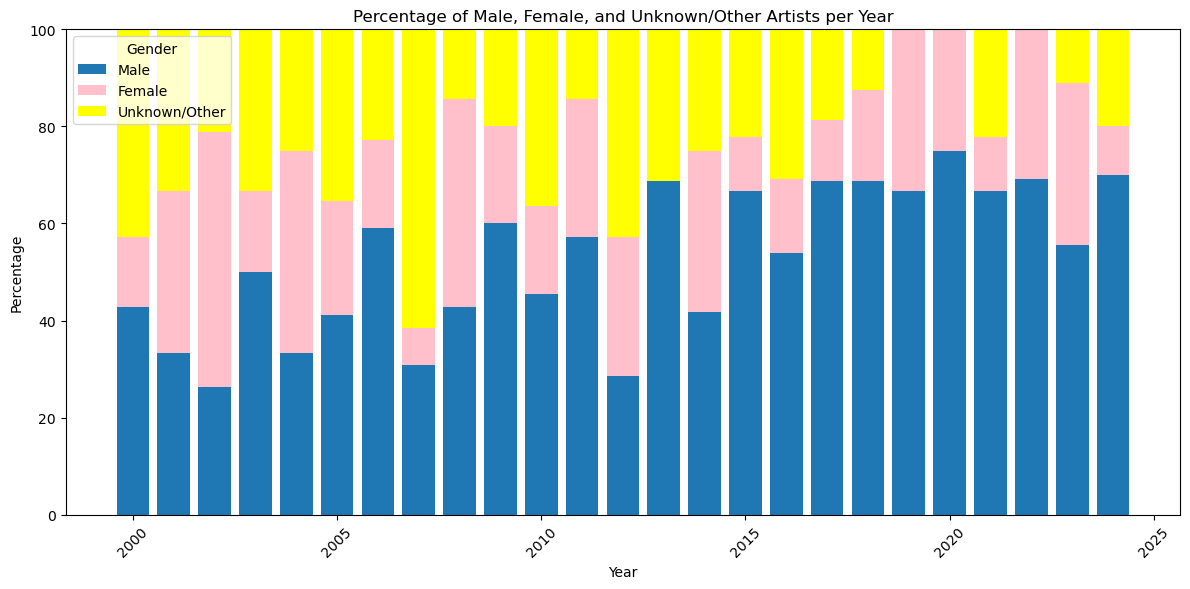

In [1013]:
# Calculate counts of male, female, and unknown/other artists per year
gender_counts = unique_top_10.groupby(['chart_year', 'gender']).size().reset_index(name='counts')

# Pivot the data to have genders as columns
gender_pivot = gender_counts.pivot(index='chart_year', columns='gender', values='counts').fillna(0)

# Calculate percentages
gender_pivot['total'] = gender_pivot.sum(axis=1)
gender_pivot['male_percentage'] = (gender_pivot['male'] / gender_pivot['total']) * 100
gender_pivot['female_percentage'] = (gender_pivot['female'] / gender_pivot['total']) * 100
gender_pivot['unknown_other_percentage'] = (gender_pivot['Unknown/Other'] / gender_pivot['total']) * 100

# Plot the stacked bar graph
plt.figure(figsize=(12, 6))

# Male percentage in default blue
plt.bar(gender_pivot.index, gender_pivot['male_percentage'], label='Male', width=0.8, color='#1f77b4') 

# Female percentage in pink
plt.bar(gender_pivot.index, gender_pivot['female_percentage'], 
        bottom=gender_pivot['male_percentage'], label='Female', width=0.8, color='pink')

# Unknown/Other percentage in yellow
plt.bar(gender_pivot.index, gender_pivot['unknown_other_percentage'], 
        bottom=gender_pivot['male_percentage'] + gender_pivot['female_percentage'], 
        label='Unknown/Other', width=0.8, color='yellow')

plt.title('Percentage of Male, Female, and Unknown/Other Artists per Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Not Enough Data

I would have liked to see if #MeToo or the overturning of Roe v Wade affected what music people listened to but unfortunately too many of the artists show up as Unknown and it would be too time-consuming to manually add genders to 200+ artists. 

## Primary Conclusions

While the audio features of charting songs clearly go through trend cycles, the influence of external societal factors such as specific events are generally hard to distinguish. While some songs are written as commentary on society and its issues, this is not necessarily the norm. It is likely that the main influence in music trends is the music industry itself. However, a couple of trends do seem to correlate with externalities.
- The economy, when taken as a whole, seems to have some influence over the danceability, energy, valence, and tempo of charting music.
- Specific economic indicators should not be used.
- The amount of explicit music in the Billboard chart has been increasing. This coincides with lower life satisfaction, as well as cultural shifts in morality and social media use.
- The data for gender was too limited for analysis.

# Presentation

## Executive Summary
Upon comparing several societal events and trends to the trends found in the music on the Billboard Hot 100, it seems that **overall, only large-scale shifts that impact all of society**, such as the Great Recession or overall shifts in life satisfaction, **have an impact** on the music that reaches the Billboard charts. 

Smaller economic measures, such as a stock market index or GDP, have little to no bearing on music trends on their own.

In addition to economic recessions, another indicator, overall life satisfaction, seems to correlate to the increase in explicit content. The political shift to the right also coincides with the decrease in life satisfaction and the increase in explicit content.

Finally, the social discussions around gender identity and equality, as well as important events pertaining to gender such as the #MeToo Movement that went viral in 2017 and the overturning of Roe v. Wade in 2022, which reversed the decision that guaranteed the constitional right to an abortion, do not seem to impact the share of female artists on the charts.

## 1. Music as an Escape: Audio Features of a Recession

### Fast Beats, Slow Economy: Music’s High Energy Amid Financial Lows
Danceability, energy, and tempo levels all increased or stayed at the same high level in the Great Recession.

However, danceability hit a bottom in the year 2010, which was after the official end date of the Great Recession but still at a time when most people were feeling the after-effects of the recession, as indicated in the high unemployment rate. 

### Audio Feature Downturns of an Economic Downturn

Despite the high energy and party-appropriate danceability of charting songs, valence (the measure for happiness) went lower. It seems that in tough times people live for the weekends while not forcing positivity. Speechiness also declined - perhaps the feel of the music was more important than messaging.

### In Crisis We Look For Comfort

The variance in charting music dropped across all audio features. People seem to have been less interested in exploring a variety of genres and instead sought out the familiar.

## 2. No Filter: Explicit Lyrics and Amplified Anger

### Music is getting more explicit as our anger rises

The share of explicit content on the Billboard Hot 100 has been rising with our levels of stress and anger.

### The shift also follows the shift in politics

The rise in explicit music does correlate to the shift to the political right. Possible explanations include pushback in response to more conservative leanings, a sense of anger directed at the political landscape, or a mixture of both.

## 3. Not Enough Data for Gender

I would have liked more information on gender but due to the restrictions in the dataset and time, I was unable to analyze this.

### Limitations

I would have liked to analyze events surrounding gender, as well as the BLM protests of 2020, however I did not have enough data for this.

I am also rusty at advanced math so I'm limited in what mathematical and statistical analysis I can do at this time.

#### Thank you for reading this notebook.